# Lane Detection in Still Images

This part of the project implements lane detection using the Canny Edge Detector and the Hough Transform. Eexamples of the lane detection performance using this method are shown below:

<img src="lane_detect_example.jpg"/>

<img src="multiimg_example.jpg"/>

### Lane Detection in Still Images Pt 1: Dependencies

In [9]:
# 3rd party dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil

### Lane Detection in Still Images Pt 2: Lane Detection Function

In [6]:
# set tuning parameters for algortithms
# gaussian blurring param:
kernel_size = 5  # Gaussian blur kernel must be odd number
# canny edge detection params:
low_thresh = 50  # low gradient threshold
hi_thresh = 150  # high gradient threshold
# hough transform params:
rho = 1  # distance resolution of the accumulator in pixels
theta = np.pi / 180  # angle resolution of the accumulator in radians
threshold = 2  # votes needed to return line (>threshold).
min_line_len = 50
max_line_gap = 20


def detect(raw_image):
    gray_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2GRAY)

    # gaussian blur + canny edge detection
    gaussian_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)
    edges_image = cv2.Canny(gaussian_image, low_thresh, hi_thresh)

    # crop
    mask = np.zeros_like(edges_image)
    imshape = raw_image.shape
    vertices = np.array([[(75, imshape[0]), (imshape[1] / 2 - 50, imshape[0] / 2 + 50),
                          (imshape[1] / 2 + 50, imshape[0] / 2 + 50), (imshape[1] - 75, imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges_image = cv2.bitwise_and(edges_image, mask)

    # lines via hough transform
    lines = cv2.HoughLinesP(masked_edges_image, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    # extract + lines from hough data structure. Associate slope so we can sort by it.
    pos_lines = [[x1, y1, x2, y2, (y2 - y1) / (x2 - x1)] for [[x1, y1, x2, y2]] in lines if
                 (y2 - y1) / (x2 - x1) >= 0]  # lines with + slope.
    pos_lines.sort(key=lambda p: p[4])  # sort by slope
    x1, y1, x2, y2, pos_M = pos_lines[len(pos_lines) // 2 - 1]  # find line with median slope
    pos_B = y1 - pos_M * x1  # compute y intercept
    # compute lane line
    pos_Y1 = int(imshape[0])
    pos_X1 = int((pos_Y1 - pos_B) / pos_M)
    pos_Y2 = int(imshape[0] / 2 + 50)
    pos_X2 = int((pos_Y2 - pos_B) / pos_M)

    # extract - lines from hough data structure. Associate slope so we can sort by it.
    neg_lines = [[x1, y1, x2, y2, (y2 - y1) / (x2 - x1)] for [[x1, y1, x2, y2]] in lines if
                 (y2 - y1) / (x2 - x1) < 0]  # lines with - slope.
    neg_lines.sort(key=lambda n: n[4])  # sort by slope
    x1, y1, x2, y2, neg_M = neg_lines[len(neg_lines) // 2 - 1]  # find line with median slope
    neg_B = y1 - neg_M * x1  # compute y intercept
    # compute lane line
    neg_Y1 = int(imshape[0])
    neg_X1 = int((neg_Y1 - neg_B) / neg_M)
    neg_Y2 = int(imshape[0] / 2 + 50)
    neg_X2 = int((neg_Y2 - neg_B) / neg_M)

    # draw lines and return image
    processed_image = np.copy(raw_image)
    cv2.line(processed_image, (pos_X1, pos_Y1), (pos_X2, pos_Y2), (255, 0, 0), 10)
    cv2.line(processed_image, (neg_X1, neg_Y1), (neg_X2, neg_Y2), (255, 0, 0), 10)
    return processed_image

### Lane Detection in Still Images Pt 3: Filesystem Prep

In [11]:
# prepare filesystem for input and output
in_dir_name = "test_images/"
out_dir_name = "result_images/"
if os.path.exists(out_dir_name):
    shutil.rmtree(out_dir_name)
os.mkdir(out_dir_name)
input_image_filenames = os.listdir(in_dir_name)

### Lane Detection in Still Images Pt 4: Processing Pipeline

processed image:  result_images/whiteCarLaneSwitch.jpg
processed image:  result_images/solidYellowCurve2.jpg
processed image:  result_images/solidYellowCurve.jpg
processed image:  result_images/solidWhiteCurve.jpg
processed image:  result_images/solidYellowLeft.jpg
processed image:  result_images/solidWhiteRight.jpg
LANE DETECTION ON ALL STILL IMAGES:


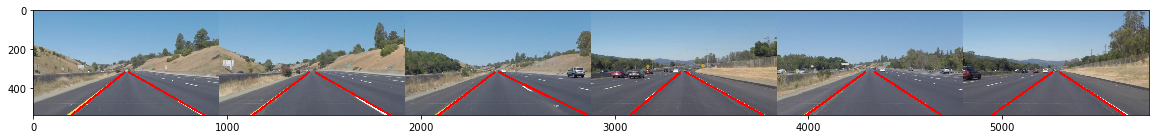

In [17]:
# execute lane lines detection for each provided image
big_image = None  # concatenated image with all still examples 
for image_filename in input_image_filenames:
    print("processed image: ", os.path.join(out_dir_name, image_filename))
    # read raw image
    raw_image = mpimg.imread(os.path.join(in_dir_name, image_filename))
    # perform line detection. see detect.py
    processed_image = detect(raw_image)
    # save processed images to disk
    fig = plt.figure(frameon=False)
    fig.set_size_inches(20, 10)
    plt.imshow(processed_image)
    plt.savefig(os.path.join(out_dir_name, "processed_" + image_filename), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    if big_image is None:
        big_image = processed_image
    else:
        big_image = np.concatenate((big_image, processed_image), axis=1)
# display concatenated image
fig = plt.figure(frameon=False)
fig.set_size_inches(20,10)
plt.imshow(big_image)
print("LANE DETECTION ON ALL STILL IMAGES:")
plt.savefig("multiimg_example.jpg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

# Lane Detection in Videos

In this part of the project, we apply the techniques we used to detect lanes in single images to detect lanes in a video stream. A naive approach is to apply 

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))